In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost
import lightgbm
import catboost
import scipy as sp
from scipy import stats
import re
import statsmodels
import statsmodels.api as sm
from scipy.stats import ttest_1samp, bartlett, levene, shapiro, probplot, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

ModuleNotFoundError: No module named 'statsmodels'

Random Forest 

In [255]:
# RandomForest 모델

# 데이터 불러오기 + 상관관계 높은 컬럼, 결측치 제거
train_data = pd.read_csv('./train.csv')
train_data = train_data.drop(columns=['CustomerID', 'MonthlyMinutes', 'TotalRecurringCharge','DirectorAssistedCalls', 
 'OverageMinutes', 'ReceivedCalls', 'PeakCallsInOut', 'PercChangeMinutes', 'BlockedCalls', 'IncomeGroup',
 'DroppedCalls', 'RetentionCalls', 'AgeHH2', 'HandsetModels']).dropna()
train_data = train_data[train_data['HandsetPrice'] != 'Unknown']

#Z-score 계산 + 이상치 제거(이상치 추가 제거가 필요할듯..)
columns_to_zscore = ['MonthlyRevenue', 'ActiveSubs', 'PercChangeRevenues']
z_scores = stats.zscore(train_data[columns_to_zscore])
outliers_mask = (abs(z_scores) > 3).any(axis=1)
train_data_cleaned = train_data[~outliers_mask]

# 종속, 독립 변수 나누기
X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0]

# 인코딩
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(X).toarray()
le = LabelEncoder()
y = le.fit_transform(y)

# 트레인, 테스트 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 스케일링
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 모델 만들기: RandomForest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
param_grid = {
    'n_estimators': [50],  # 결정 트리의 개수
    'max_depth': [30],     # 트리의 최대 깊이
    'min_samples_split': [10],     # 내부 노드를 분할하는 데 필요한 최소 샘플 수
    'min_samples_leaf': [1],       # 리프 노드에 필요한 최소 샘플 수
    'max_features': ['sqrt']  # 각 노드를 분할할 때 고려할 특성의 수
}

grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 정확도 체크하기
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1 = 2*precision*recall / (precision+recall)
accuracy = (TP+TN) / (TP+TN+FP+FN)

print('Random Forest')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')


[[3054  130]
 [1030   84]]
Random Forest
precision: 0.747796278158668
recall: 0.9591708542713567
f1: 0.8403962575674188
accuracy: 0.7301070265239646


XGBoost

In [257]:
# xgboost 모델

# 데이터 불러오기 + 상관관계 높은 컬럼, 결측치 제거
train_data = pd.read_csv('./train.csv')
train_data = train_data.drop(columns=['CustomerID', 'MonthlyMinutes', 'TotalRecurringCharge','DirectorAssistedCalls', 
 'OverageMinutes', 'ReceivedCalls', 'PeakCallsInOut', 'PercChangeMinutes', 'BlockedCalls', 'IncomeGroup',
 'DroppedCalls', 'RetentionCalls', 'AgeHH2', 'HandsetModels']).dropna()
train_data = train_data[train_data['HandsetPrice'] != 'Unknown']

#Z-score 계산 + 이상치 제거
columns_to_zscore = ['MonthlyRevenue', 'ActiveSubs', 'PercChangeRevenues']
z_scores = stats.zscore(train_data[columns_to_zscore])
outliers_mask = (abs(z_scores) > 3).any(axis=1)
train_data_cleaned = train_data[~outliers_mask]

# 종속, 독립 변수 나누기
X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0]

# 인코딩
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(X).toarray()
le = LabelEncoder()
y = le.fit_transform(y)

# 트레인, 테스트 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 스케일링
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 모델 만들기: xgboost
import xgboost
classifier = xgboost.XGBClassifier(n_estimators=80)
classifier.fit(X_train, y_train)

param_grid = {
    'n_estimators': [200],      # 트리의 개수
    'max_depth': [7],           # 각 트리의 최대 깊이
    'learning_rate': [0.01],   # 학습률
    'subsample': [0.6],        # 샘플링 비율
    'colsample_bytree': [1.0]  # 각 트리를 만들 때 고려할 특성의 비율
}

grid_search = GridSearchCV(classifier, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

test_score = grid_search.score(X_test, y_test)
print("Test score:", test_score)

# 정확도 체크하기
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1 = 2*precision*recall / (precision+recall)
accuracy = (TP+TN) / (TP+TN+FP+FN)

print('XGBoost')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')

Test score: 0.7429036761284318
[[3004  180]
 [ 958  156]]
XGBoost
precision: 0.7582029278142353
recall: 0.9434673366834171
f1: 0.8407500699692136
accuracy: 0.7352256863657515


Logistic Regression

In [252]:
# Logistic Regression 모델

# 데이터 불러오기 + 상관관계 높은 컬럼, 결측치 제거
train_data = pd.read_csv('./train.csv')
train_data = train_data.drop(columns=['CustomerID', 'MonthlyMinutes', 'TotalRecurringCharge','DirectorAssistedCalls', 
 'OverageMinutes', 'ReceivedCalls', 'PeakCallsInOut', 'PercChangeMinutes', 'BlockedCalls', 'IncomeGroup',
 'DroppedCalls', 'RetentionCalls', 'AgeHH2', 'HandsetModels']).dropna()
train_data = train_data[train_data['HandsetPrice'] != 'Unknown']

#Z-score 계산 + 이상치 제거
columns_to_zscore = ['MonthlyRevenue', 'ActiveSubs', 'PercChangeRevenues']
z_scores = stats.zscore(train_data[columns_to_zscore])
outliers_mask = (abs(z_scores) > 3).any(axis=1)
train_data_cleaned = train_data[~outliers_mask]

# 종속, 독립 변수 나누기
X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0]

# 인코딩
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')
X = ct.fit_transform(X).toarray()
le = LabelEncoder()
y = le.fit_transform(y)

# 트레인, 테스트 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# 스케일링
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 모델 만들기: Logistic Regression
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Hyperparameter Tuning
param_grid = {'C': [0.01], 'solver': ['newton-cg']}
grid_search = GridSearchCV(classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# 최적의 모델 학습 + 모델 평가
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Score:", test_score)

# 정확도 체크하기
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

TP = cm[0, 0]
FN = cm[0, 1]
FP = cm[1, 0]
TN = cm[1, 1]

precision = TP / (TP+FP)
recall = TP / (TP+FN)
f1 = 2*precision*recall / (precision+recall)
accuracy = (TP+TN) / (TP+TN+FP+FN)

print('Logistic Regression')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'accuracy: {accuracy}')

Test Score: 0.7347603536528617
[[3085   99]
 [1037   77]]
Logistic Regression
precision: 0.7484230955846677
recall: 0.9689070351758794
f1: 0.8445113605255954
accuracy: 0.7356910190786412


Extra Task: 중요도 확인

In [45]:
# feature 중요도 확인
importances = classifier.feature_importances_

# 중요도를 DataFrame으로 변환
feature_names = ct.get_feature_names_out()  # 인코딩된 특성 이름 가져오기
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 중요도 기준으로 정렬
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance_df.iloc[730:780, :]

,Feature,Importance
807,encoder__Occupation_Retired,0.000928
58,encoder__ServiceArea_ATLATL678,0.000932
56,encoder__ServiceArea_ATLANE678,0.000932
472,encoder__ServiceArea_NYCQUE917,0.000942
263,encoder__ServiceArea_KCYKCM816,0.000953
108,encoder__ServiceArea_CHICHI773,0.000960
143,encoder__ServiceArea_DENDEN303,0.000966
734,encoder__ServiceArea_STLSTL314,0.000990
618,encoder__ServiceArea_SANAUS512,0.000991
332,encoder__ServiceArea_MIAMIA305,0.000996


In [9]:
data2 = pd.concat([train_data.iloc[:, 0], train_data.iloc[:, 10: 21]], axis=1)

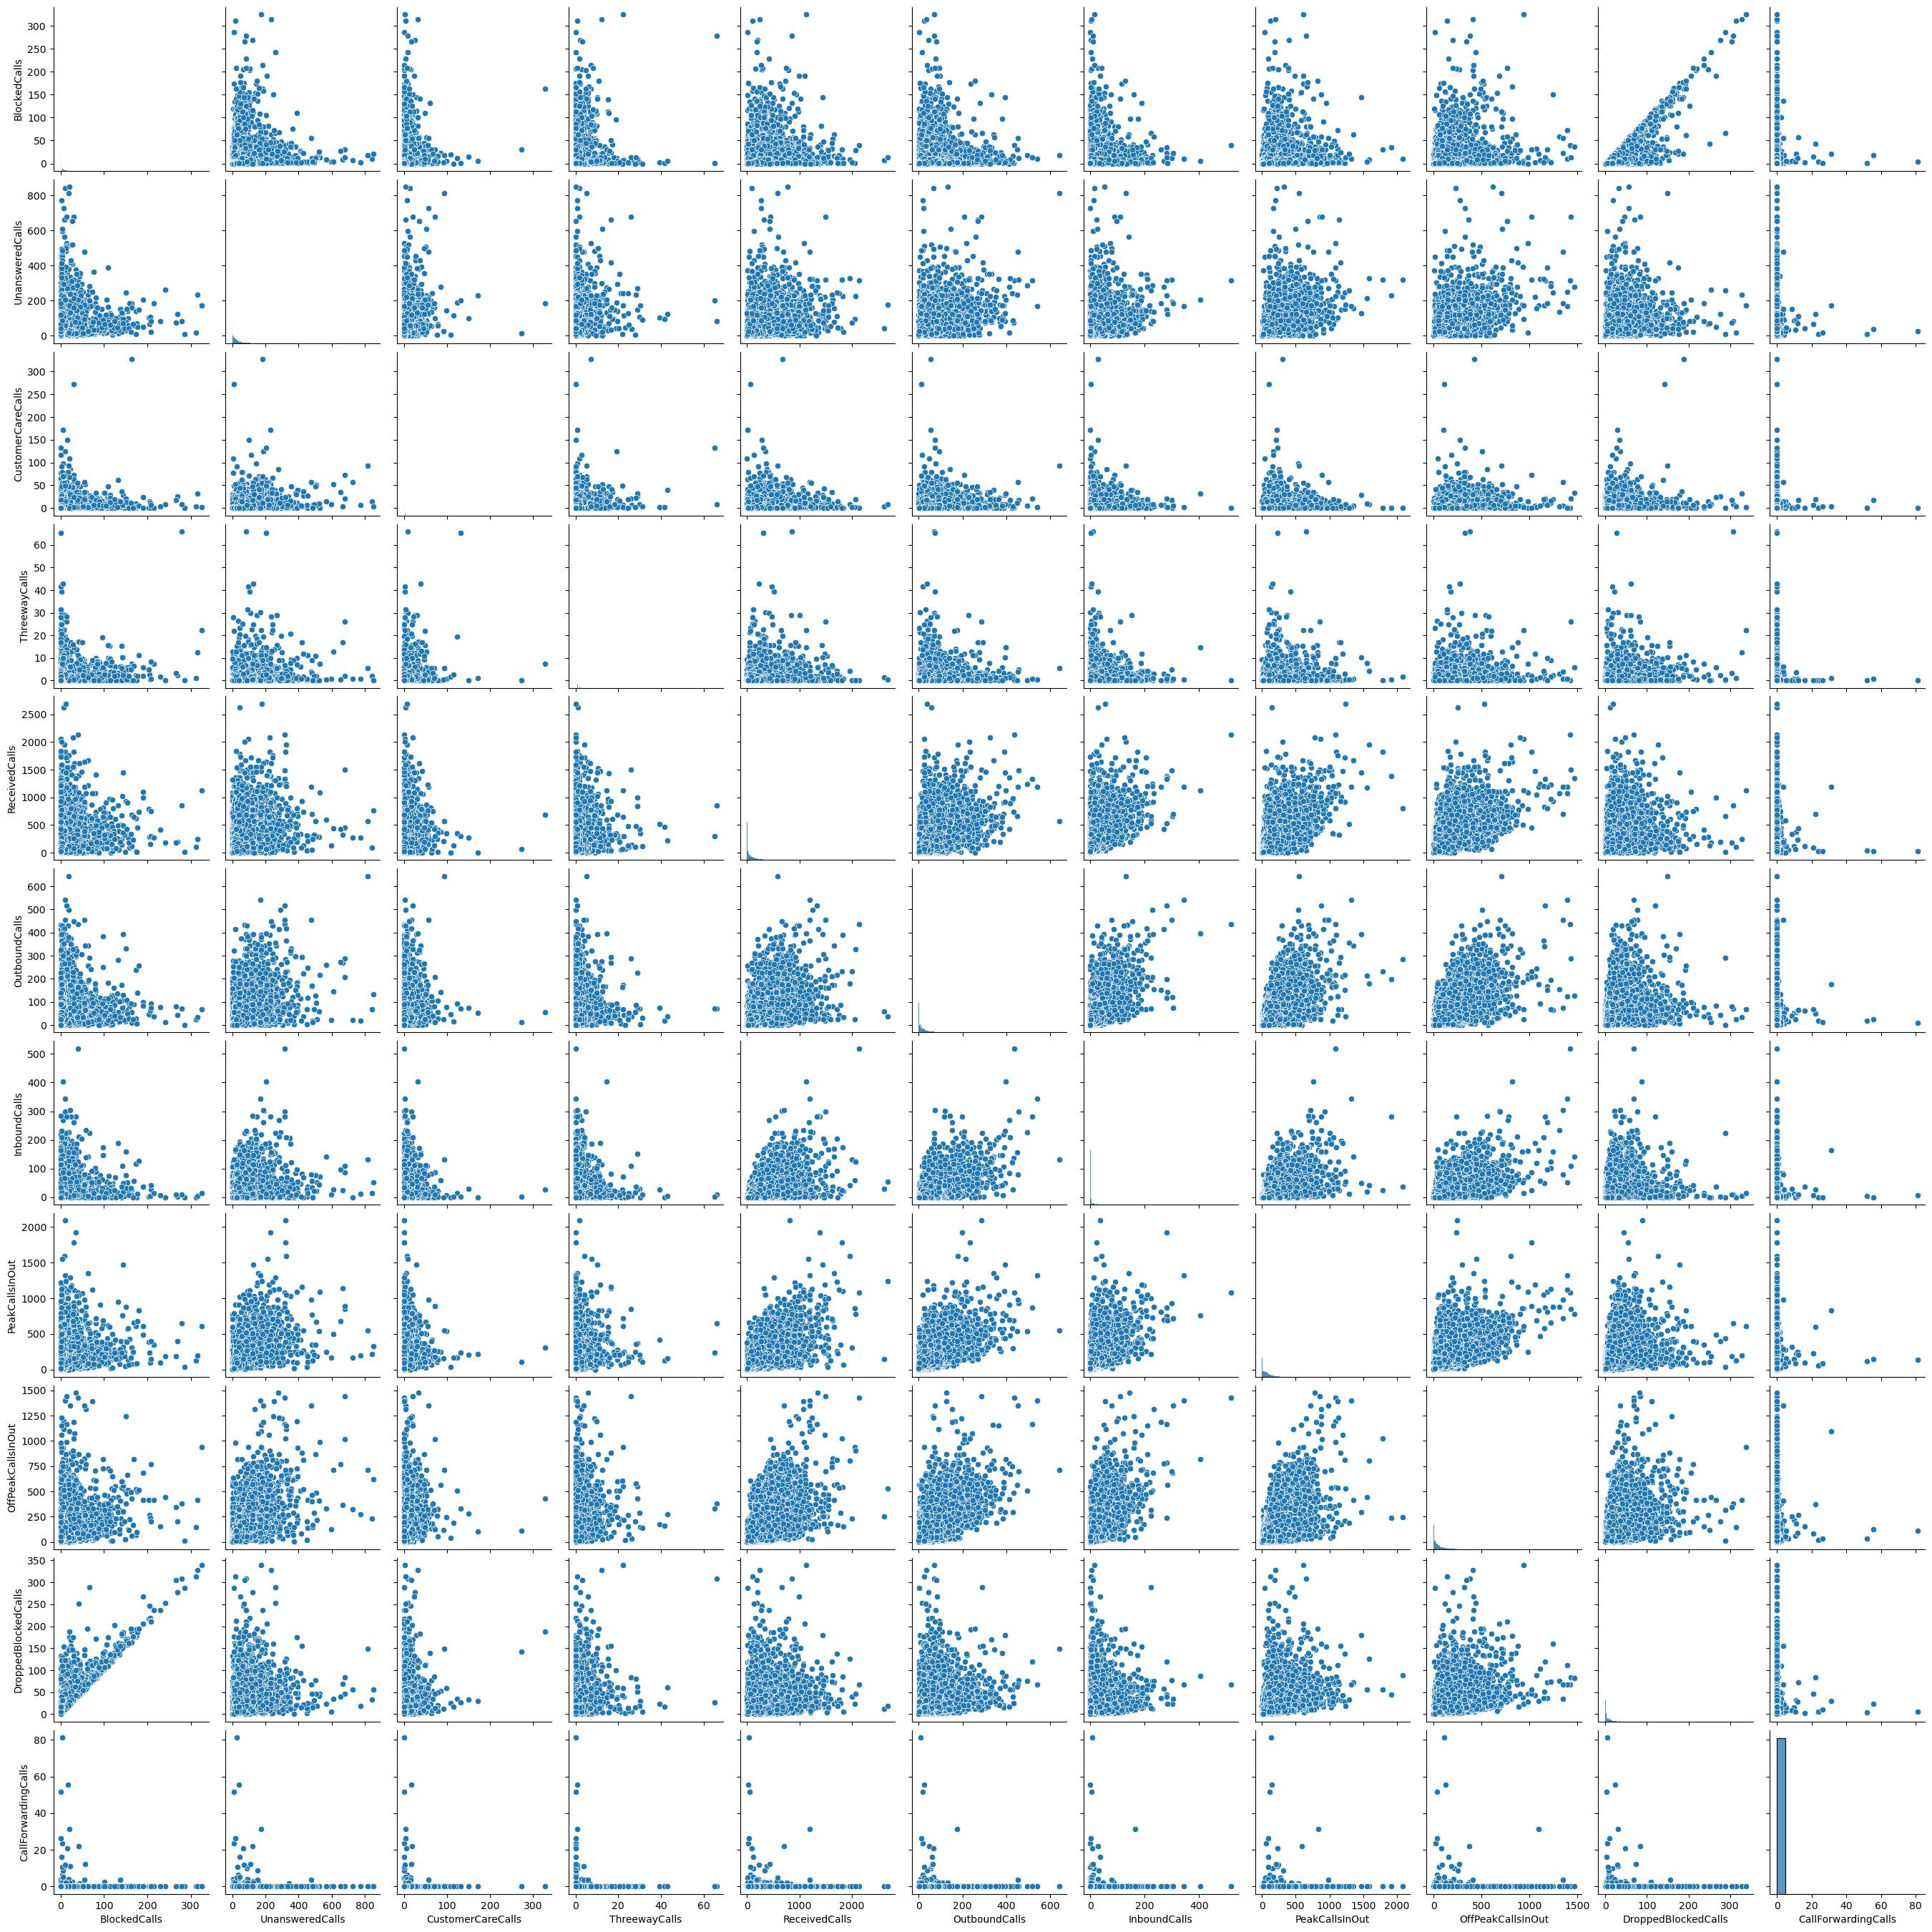

In [10]:
sns.pairplot(data2)

In [4]:
pd.read_csv('./test.csv')

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000006,NaN,57.49,483.0,37.0,0.25,23.0,0.0,532.0,51.0,...,0,5,No,1,150,No,5-Low,Other,Other,No
1,3000018,NaN,55.23,570.0,72.0,0.00,0.0,0.0,38.0,0.0,...,0,6,No,2,80,No,1-Highest,Other,Professional,No
2,3000034,NaN,97.34,1039.0,50.0,4.95,420.0,0.0,198.0,23.3,...,0,4,No,3,10,No,3-Good,Suburban,Crafts,Yes
3,3000070,NaN,35.59,153.0,30.0,0.00,16.0,0.0,30.0,7.3,...,0,4,No,1,200,No,1-Highest,Other,Other,No
4,3000074,NaN,55.27,1213.0,50.0,0.74,0.0,1.3,169.0,1.0,...,0,3,No,0,10,No,1-Highest,Suburban,Other,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3399938,NaN,85.15,815.0,88.0,0.00,1.0,0.4,0.0,0.0,...,0,0,No,0,40,No,1-Highest,Other,Other,Unknown
19996,3399950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,6,No,0,Unknown,No,1-Highest,Suburban,Other,Yes
19997,3399966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,8,No,1,Unknown,No,1-Highest,Suburban,Other,No
19998,3399970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,3,No,0,150,No,3-Good,Other,Other,Unknown
